In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.xception import Xception, preprocess_input
import matplotlib.pyplot as plt
import cv2

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.array([cv2.resize(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (71, 71)) for img in x_train])
x_test = np.array([cv2.resize(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (71, 71)) for img in x_test])
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
print('Training', x_train.shape)
print('Testing', x_test.shape)

Training (60000, 71, 71, 3)
Testing (10000, 71, 71, 3)


In [ ]:
base_model = Xception(include_top=False, input_shape=(71, 71, 3))
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(10, activation="softmax")(x)
feature_model = keras.models.Model(inputs=base_model.input, outputs=x)
feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]']    

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
feature_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
feature_model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/5
469/469 [==============================] - 55s 92ms/step - loss: 0.6279 - accuracy: 0.8128 - val_loss: 0.6608 - val_accuracy: 0.8189
Epoch 2/5
469/469 [==============================] - 38s 80ms/step - loss: 0.4807 - accuracy: 0.8573 - val_loss: 0.5674 - val_accuracy: 0.8484
Epoch 3/5
469/469 [==============================] - 38s 80ms/step - loss: 0.4531 - accuracy: 0.8668 - val_loss: 0.6813 - val_accuracy: 0.8389
Epoch 4/5
469/469 [==============================] - 36s 78ms/step - loss: 0.4292 - accuracy: 0.8742 - val_loss: 0.6718 - val_accuracy: 0.8394
Epoch 5/5
469/469 [==============================] - 42s 90ms/step - loss: 0.4179 - accuracy: 0.8822 - val_loss: 0.8174 - val_accuracy: 0.8363


In [ ]:
loss, accuracy = feature_model.evaluate(x_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 15s 22ms/step - loss: 0.8174 - accuracy: 0.8363
Test loss: 0.8173946738243103
Test accuracy: 0.8363000154495239


In [ ]:
img_a_in = keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = keras.layers.concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = keras.layers.Dense(16, activation='linear')(combined_features)
combined_features = keras.layers.BatchNormalization()(combined_features)
combined_features = keras.layers.Activation('relu')(combined_features)
combined_features = keras.layers.Dense(4, activation='linear')(combined_features)
combined_features = keras.layers.BatchNormalization()(combined_features)
combined_features = keras.layers.Activation('relu')(combined_features)
combined_features = keras.layers.Dense(1, activation='sigmoid')(combined_features)
siamese_model = keras.models.Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name = 'Similarity_Model')
siamese_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           21045810    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['model[0][0]',   

In [ ]:
siamese_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


1/1 [==============================] - 3s 3s/step


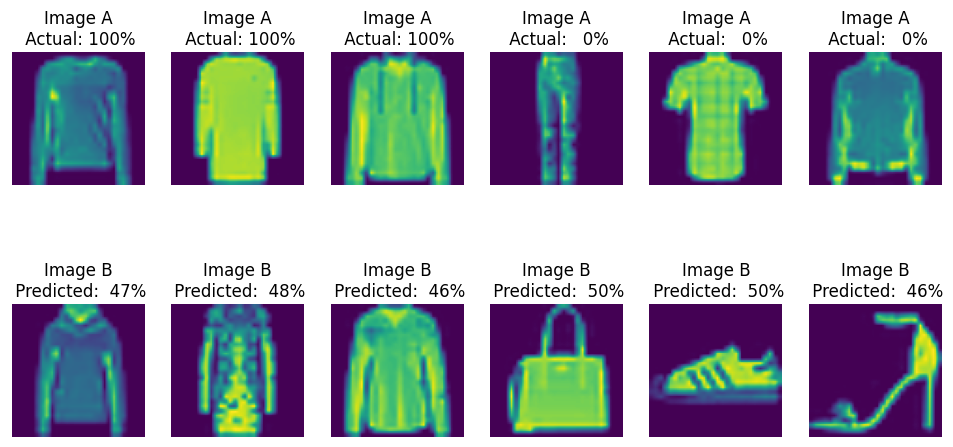

In [ ]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()


In [ ]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit_generator(siam_gen(train_groups), 
                                              steps_per_epoch=500, 
                                              validation_data=([valid_a, valid_b], valid_sim), 
                                              epochs=15, 
                                              verbose=True)

<ipython-input-15-4724bb0c98ce>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = siamese_model.fit_generator(siam_gen(train_groups),


Epoch 1/15
500/500 [==============================] - 41s 65ms/step - loss: 0.5957 - mae: 0.4245 - val_loss: 0.5343 - val_mae: 0.3867
Epoch 2/15
500/500 [==============================] - 29s 58ms/step - loss: 0.5384 - mae: 0.3796 - val_loss: 0.5011 - val_mae: 0.3620
Epoch 3/15
500/500 [==============================] - 28s 56ms/step - loss: 0.4907 - mae: 0.3410 - val_loss: 0.4674 - val_mae: 0.3189
Epoch 4/15
500/500 [==============================] - 28s 57ms/step - loss: 0.4588 - mae: 0.3137 - val_loss: 0.4485 - val_mae: 0.2973
Epoch 5/15
500/500 [==============================] - 28s 57ms/step - loss: 0.4640 - mae: 0.3100 - val_loss: 0.4823 - val_mae: 0.3105
Epoch 6/15
500/500 [==============================] - 28s 56ms/step - loss: 0.4521 - mae: 0.3024 - val_loss: 0.4428 - val_mae: 0.2951
Epoch 7/15
500/500 [==============================] - 28s 57ms/step - loss: 0.4336 - mae: 0.2845 - val_loss: 0.4997 - val_mae: 0.3079
Epoch 8/15
500/500 [==============================] - 28s 56ms

1/1 [==============================] - 0s 30ms/step


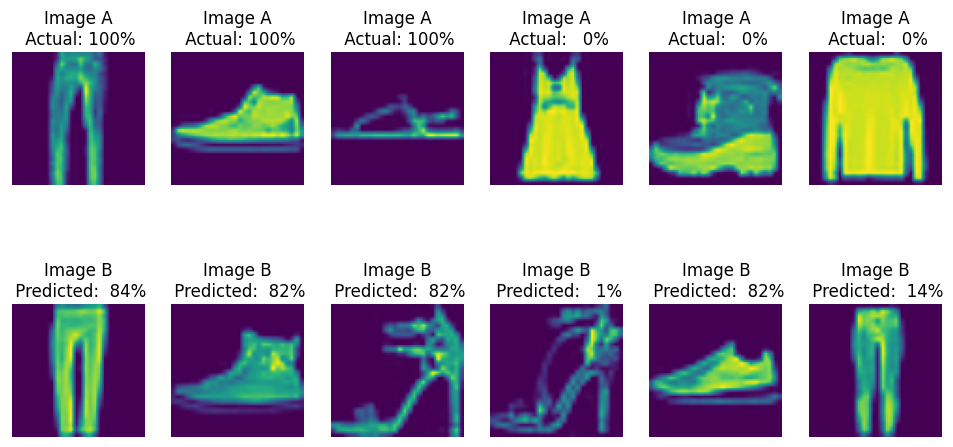

In [ ]:
_= show_model_output()

In [ ]:
x_test_features = feature_model.predict(x_test, verbose=True, batch_size=128)

79/79 [==============================] - 7s 61ms/step


In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.543s
[t-SNE] Iteration 50: error = 80.3654175, gradient norm = 0.0229472 (50 iterations in 4.865s)
[t-SNE] It

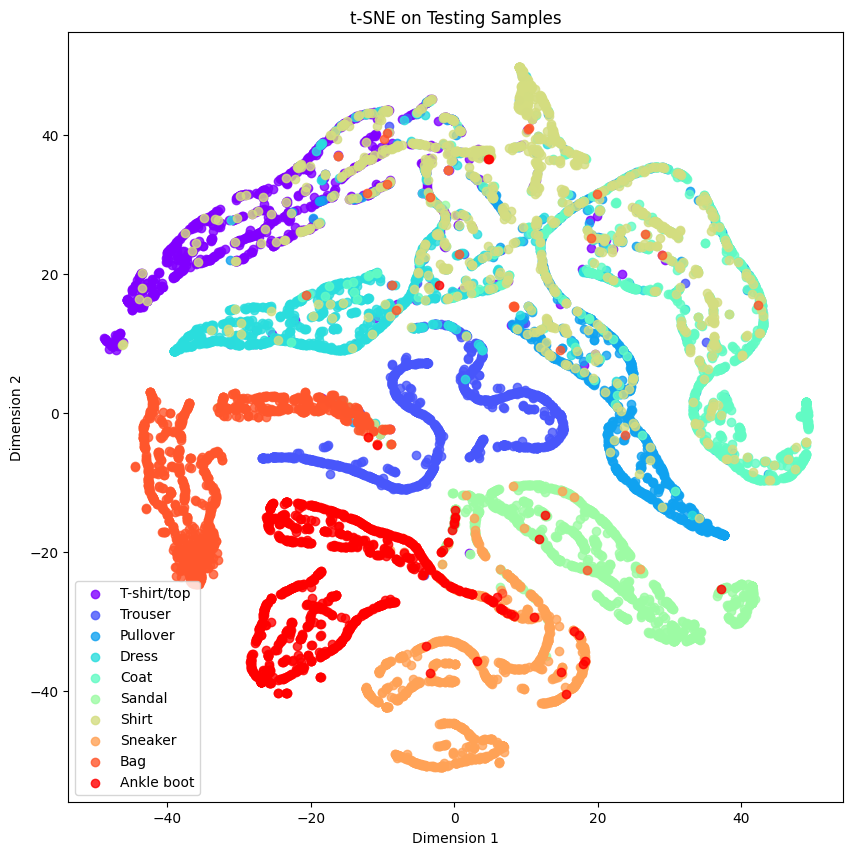

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)